To start this is the supplied by Dr. Sievers

In [2]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time

In [3]:
def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

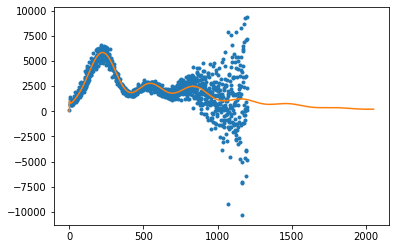

In [4]:
plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(pars)
plt.plot(cmb)
plt.show(block=True)

Question 1

In [5]:
# gets the spectrum at the same pionts as data
def get_spectrum2(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    tt=tt[wmap[:,0].astype(int)]
    return tt

In [6]:
fit=get_spectrum2(pars)
data=wmap[:,1]
err=wmap[:,2]
top=np.power((fit-data),2)
bottom=np.power(err,2)
X_sq=np.sum(np.divide(top,bottom))
print('the chi squared value is', X_sq)

the chi squared value is 1588.2376465826746


I get a $\chi^2$ value of 1588.238 which should be expected

Question 2

for a dervtive I will be using $\frac{df}{dx}=\frac{f(x+dx)-f(x)}{dx}$ with $dx=1$ since our data occurs at integver values

In [7]:
def Ap(pars,fit,x): # fit is already calculated in chi_sq
    Ap=np.zeros([5,len(fit)])
    Ap[0,:]=(get_spectrum2(pars+[pars[0]/x,0,0,0,0,0])-fit)/(pars[0]/x)
    Ap[1,:]=(get_spectrum2(pars+[0,pars[1]/x,0,0,0,0])-fit)/(pars[1]/x)
    Ap[2,:]=(get_spectrum2(pars+[0,0,pars[2]/x,0,0,0])-fit)/(pars[2]/x)
    Ap[3,:]=(get_spectrum2(pars+[0,0,0,0,(pars[4]/x),0])-fit)/(pars[4]/x)
    Ap[4,:]=(get_spectrum2(pars+[0,0,0,0,0,(pars[5]/x)])-fit)/(pars[5]/x)
    return Ap.transpose()

def Ap_full(pars,fit,x): # fit is already calculated in chi_sq
    Ap=np.zeros([len(pars),len(fit)])
    dumy=np.zeros(len(pars))
    for i in range(len(pars)):
            dumy[i]=pars[i]/x
            Ap[i,:]=(get_spectrum2(pars+dumy)-fit)/(pars[i]/x)
            dumy[i]=0
    return Ap.transpose()


In [8]:
lam=1
max_steps=10
N=np.zeros([len(data),len(data)])
for i in range(len(data)):
    N[i,i]=err[i]**2
chi_sq=np.zeros(max_steps+1)
Ninv=np.linalg.inv(N)
chi_sq[0]=X_sq

In [9]:
for i in range(1,max_steps):
    dA=Ap(pars,fit,100)
    lhs=np.dot(dA.transpose(),np.dot(Ninv,dA))
    rhs=np.dot(dA.transpose(),np.dot(Ninv,data-fit))
    lhs=lhs+lam*np.diag(np.diag(lhs))
    dm=np.dot(np.linalg.inv(lhs),rhs)
    pars=pars+[dm[0],dm[1],dm[2],0,dm[3],dm[4]]
    fit=get_spectrum2(pars)
    top=np.power((fit-data),2)
    bottom=np.power(err,2)
    chi_sq[i]=np.sum(np.divide(top,bottom))
    del_chi=chi_sq[i]-chi_sq[i-1]
    if np.abs(del_chi)<.2:
        print('stopped after ',i,'iterations')
        break
    lam=lam*2**(del_chi/100)
if chi_sq[-1]!=0:
    print('reached iteration limit of', maxsteps)
                
parsQ2=np.copy(pars) # saving the pars from Q2     

In [10]:
cov=np.linalg.inv(lhs)

array([1588.23764658, 1295.44573182, 1234.41530754, 1230.86093887,
       1229.70761649, 1229.13614539, 1228.80361579, 1228.58438325,
       1228.42717016, 1228.31134074, 1228.22607648])

In [11]:
err_chi=np.sqrt(np.diag(cov))

In [12]:
print('the hubble constant is', pars[0],'with an error of',err_chi[0])
print('the physical baryon density is', pars[1],'with an error of',err_chi[1])
print('the cold dark matter density is', pars[2],'with an error of',err_chi[2])
print('the primordial amplitude of fluctations is', pars[4],'with an error of',err_chi[3])
print('the slope of the priomordial power law is', pars[5],'with an error of',err_chi[4])

the hubble constant is 70.59567899953954 with an error of 1.1473013894055544
the physical baryon density is 0.022548159561846828 with an error of 0.0003805913787019236
the cold dark matter density is 0.11075334776726567 with an error of 0.0018527875000258797
the primordial amplitude of fluctations is 2.0200581955470196e-09 with an error of 1.6091894854876494e-11
the slope of the priomordial power law is 0.9729884371365463 with an error of 0.00888693404534759


if our step dervitives are valid we should be able to change the step size and have no significant cchange to our chi square in another iteration 

In [13]:
# we are taking another step with the step size reduced by 10 
i=i+1
dA=Ap(pars,fit,10)
lhs=np.dot(dA.transpose(),np.dot(Ninv,dA))
rhs=np.dot(dA.transpose(),np.dot(Ninv,data-fit))
lhs=lhs+lam*np.diag(np.diag(lhs))
dm=np.dot(np.linalg.inv(lhs),rhs)
pars=pars+[dm[0],dm[1],dm[2],0,dm[3],dm[4]]
fit=get_spectrum2(pars)
top=np.power((fit-data),2)
bottom=np.power(err,2)
chi_sq[i]=np.sum(np.divide(top,bottom))
del_chi=chi_sq[i]-chi_sq[i-1]
print(del_chi)

-0.08526426650905705


Note that change is not significant!

If we were to allow  $\tau$ to vary as well we would see an increase in error in all of our paramters since we are adding another paramter. But specficly since optical path length of the primordial universe is hard to calculate without polarization data which we don't use the error of parameter with dependence on $\tau$ would skyrocket

Question 3

I will start by using the results from question 2 to get a covarince matrix that includes $\tau=0.1$

In [14]:
dA=Ap_full(pars,fit,100)
lhs=np.dot(dA.transpose(),np.dot(Ninv,dA))
cov=np.linalg.inv(lhs)

In [15]:
def par_step(par,step):
    param_scalings=step*par
    return par+param_scalings*np.random.randn(len(par))
def take_step_cov(covmat):
    mychol=np.linalg.cholesky(covmat)
    return np.dot(mychol,np.random.randn(covmat.shape[0]))

In [19]:
scale_fac=0.5
chisq=chi_sq[i]
nstep=10000
chain=np.zeros([nstep,len(pars)])
chisqvec=np.zeros(nstep)
pars=parsQ2
t=time.time()
count=0
for ii in range(nstep):
    new_pars=pars+take_step_cov(cov)*scale_fac
    if new_pars[3]>0:
        fit=get_spectrum2(new_pars)
        new_chisq=np.sum(np.divide(np.power((fit-data),2),np.power(err,2)))    
        delta_chisq=new_chisq-chisq
        prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<prob
        if accept:
            pars=new_pars
            chisq=new_chisq
            count=count+1
    chain[ii,:]=pars
    chisqvec[ii]=chisq
    np.savetxt('Q3.csv', chain, delimiter=',')
np.savetxt('Q3_final.csv', chain, delimiter=',')
print((time.time()-t)/60,'min')

4.919767379760742e-05 min


In [46]:
chain=np.loadtxt('Q3_final_good.csv',delimiter=',') #just in case the data is lost
nstep=10000

In [123]:
MCMC_pars=np.mean(chain,axis=0)
MCMC_err=np.std(chain,axis=0)/np.sqrt((nstep*.2)/2) #making an estimate that half the data points are uncorrelated
#multiply by .2 since the acceptence rate was .2

In [124]:
print('the hubble constant is', MCMC_pars[0],'with an error of',MCMC_err[0])
print('the physical baryon density is', MCMC_pars[1],'with an error of',MCMC_err[1])
print('the cold dark matter density is', MCMC_pars[2],'with an error of',MCMC_err[2])
print('the optical path length is', MCMC_pars[3],'with an error of',MCMC_err[3])
print('the primordial amplitude of fluctations is', MCMC_pars[4],'with an error of',MCMC_err[4])
print('the slope of the priomordial power law is', MCMC_pars[5],'with an error of',MCMC_err[5])

the hubble constant is 72.7233807385854 with an error of 0.11596218355699157
the physical baryon density is 0.023131893177883573 with an error of 2.424806708058767e-05
the cold dark matter density is 0.10803947201637938 with an error of 0.00020552827519379496
the optical path length is 0.1306308442604483 with an error of 0.00201331773990426
the primordial amplitude of fluctations is 2.3823977699100364e-09 with an error of 8.712217667659466e-12
the slope of the priomordial power law is 0.9921330535689258 with an error of 0.0007318246599024863


To show that the MCMC chain has converged we will show that the last 2000 pionts are just a fluctuation about the mean so are white noise and the fourier transform will be falt for low k this can be done with any paramter I will show it with the cold dark matter density since dark matter is cool

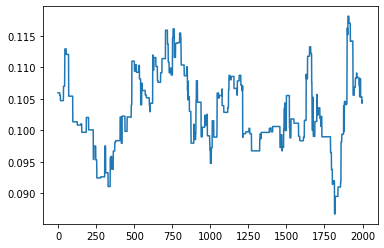

In [125]:
test_par=2
noise=chain[nstep-2000:nstep,test_par]
plt.plot(noise)
plt.show()

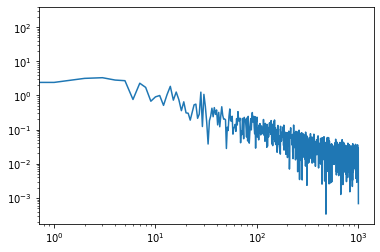

In [126]:
F_noise=np.fft.rfft(noise)
plt.loglog(np.abs(F_noise)) 
plt.show()

We can see it starts flat as expected

Question 4

In [127]:
mu=0.0544
sig=0.0073
def pri(tau):
    p=np.exp(-(tau-mu)**2/(2*sig**2))
    return p

In [128]:
chain2=np.zeros([nstep,len(pars)])
pars=chain[0,:]
count2=0
for i in range(len(chain)):
    new_pars=chain[i,:]
    prob=pri(new_pars[3])
    accept=np.random.rand(1)<prob
    if accept:
        pars=new_pars
        count2=count2+1
    chain2[i,:]=pars
    

In [129]:
MCMC_pars=np.mean(chain2,axis=0)
MCMC_err=np.std(chain2,axis=0)/np.sqrt(count2/2) #making an estimate that half the data points are uncorrelated

In [130]:
print('the hubble constant is', MCMC_pars[0],'with an error of',MCMC_err[0])
print('the physical baryon density is', MCMC_pars[1],'with an error of',MCMC_err[1])
print('the cold dark matter density is', MCMC_pars[2],'with an error of',MCMC_err[2])
print('the optical path length is', MCMC_pars[3],'with an error of',MCMC_err[3])
print('the primordial amplitude of fluctations is', MCMC_pars[4],'with an error of',MCMC_err[4])
print('the slope of the priomordial power law is', MCMC_pars[5],'with an error of',MCMC_err[5])

the hubble constant is 70.59861027319165 with an error of 0.13196759334757585
the physical baryon density is 0.02259888169460319 with an error of 2.3815907163383344e-05
the cold dark matter density is 0.11152731157714305 with an error of 0.0002592179951125966
the optical path length is 0.06878434509459842 with an error of 0.0016603192615047726
the primordial amplitude of fluctations is 2.1104996389411833e-09 with an error of 6.361921928599567e-12
the slope of the priomordial power law is 0.9740726200026358 with an error of 0.0006595445932653717


These results appear to be much lower than those of the previous chain probbaly becuase of the difference in optical path length 